# Interactions

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import theano
import arviz as az

import warnings
warnings.filterwarnings("ignore")

### Building an interaction

###### Code 7.1

In [4]:
d = pd.read_csv("../../data/rugged.csv", sep=';')

d["log_gdp"] = np.log(d["rgdppc_2000"])
dd = d.dropna(subset=["rgdppc_2000"])
d_a1 = dd.query("cont_africa == 1")
d_a0 = dd.query("cont_africa == 0")

###### Code 7.2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1516.70draws/s]


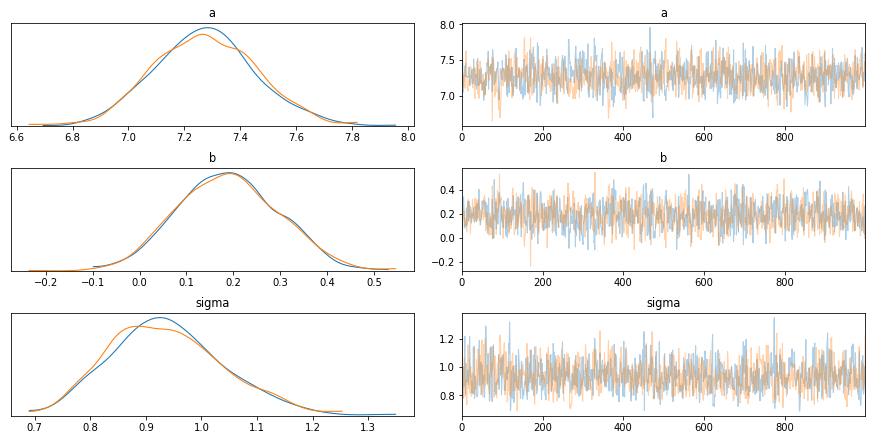

In [12]:
# African Nations
with pm.Model() as m7_1:
    a = pm.Normal('a', mu=8, sd=100)
    br = pm.Normal('b', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + br * d_a1["rugged"])
    sigma = pm.Uniform('sigma', 0, 10)
    r = pm.Normal('rugged', mu=mu, sd=sigma, observed=d_a1["log_gdp"])
    trace_m7_1 = pm.sample(1000, tune=1000)
    
varnames = ['~mu']
pm.traceplot(trace_m7_1, varnames);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 983.20draws/s] 
The acceptance probability does not match the target. It is 0.8911252278568043, but should be close to 0.8. Try to increase the number of tuning steps.


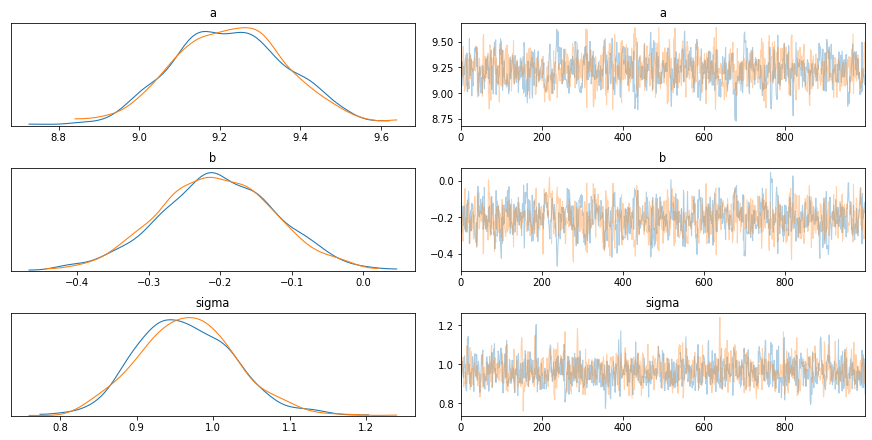

In [13]:
# non-African Nations
with pm.Model() as m7_2:
    a = pm.Normal('a', mu=8, sd=100)
    br = pm.Normal('b', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + br * d_a0["rugged"])
    sigma = pm.Uniform('sigma', 0, 10)
    r = pm.Normal('rugged', mu=mu, sd=sigma, observed=d_a0["log_gdp"])
    trace_m7_2 = pm.sample(1000, tune=1000)

varnames = ['~mu']
pm.traceplot(trace_m7_2, varnames);

###### Figure 7.2

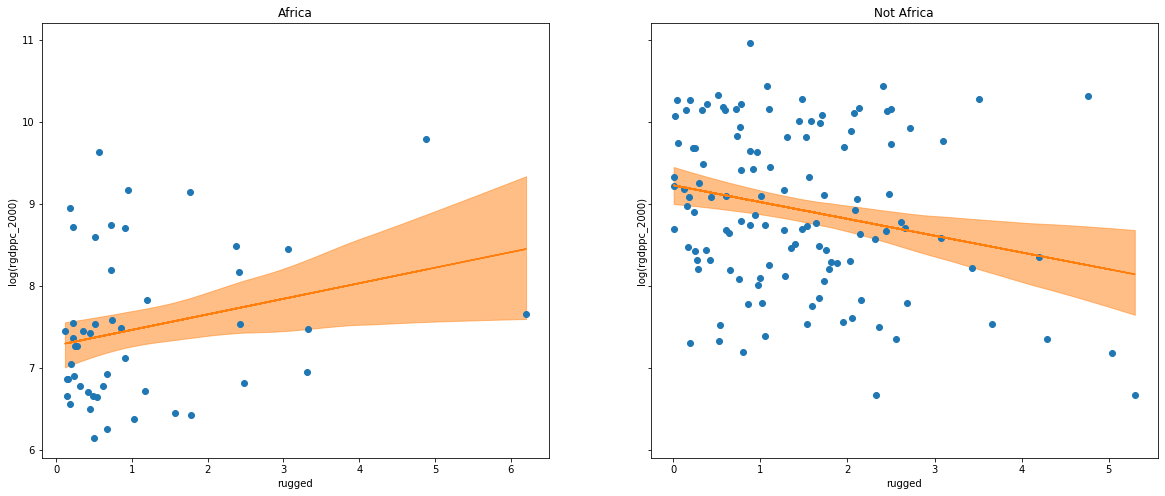

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8), sharey=True)

mu_mean = trace_m7_1["mu"]


ax1.plot(d_a1["rugged"], d_a1["log_gdp"], 'C0o')
ax1.plot(d_a1["rugged"], mu_mean.mean(axis=0), 'C1')
az.plot_hpd(d_a1["rugged"], mu_mean, ax=ax1, credible_interval=0.89)
ax1.set_title('Africa')
ax1.set_ylabel('log(rgdppc_2000)');
ax1.set_xlabel('rugged')

mu_mean = trace_m7_2["mu"]

ax2.plot(d_a0["rugged"], d_a0["log_gdp"], 'C0o')
ax2.plot(d_a0["rugged"], mu_mean.mean(axis=0), 'C1')
az.plot_hpd(d_a0["rugged"], mu_mean, ax=ax2, credible_interval=0.89)
ax2.set_title('Not Africa')
ax2.set_ylabel('log(rgdppc_2000)')
ax2.set_xlabel('rugged')

plt.show();

###### Code 7.3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1593.01draws/s]


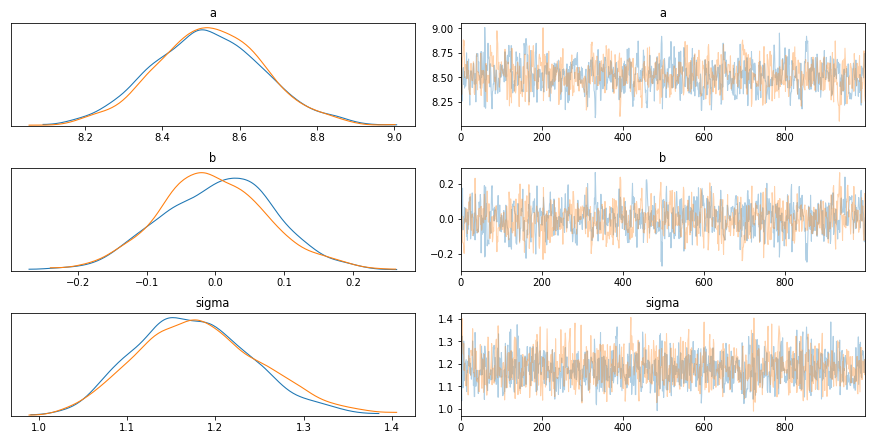

In [29]:
with pm.Model() as m7_3:
    a = pm.Normal('a', mu=8, sd=100)
    br = pm.Normal('b', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + br * dd["rugged"])
    sigma = pm.Uniform('sigma', 0, 10)
    r = pm.Normal('rugged', mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace_m7_3 = pm.sample(1000, tune=1000)

varnames = ['~mu']
pm.traceplot(trace_m7_3, varnames);

###### Code 7.4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ba, br, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1272.83draws/s]


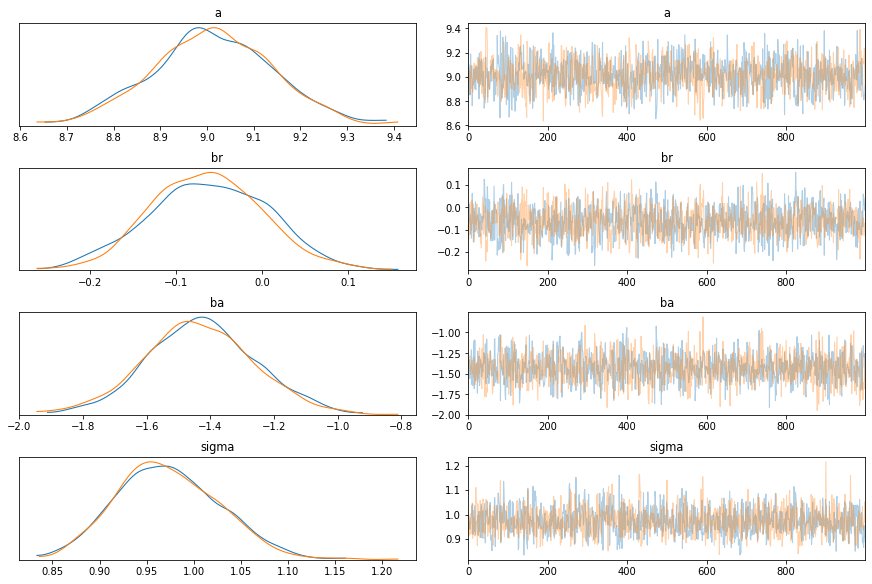

In [32]:
with pm.Model() as m7_4:
    a = pm.Normal('a', mu=8, sd=100)
    br = pm.Normal('br', mu=0, sd=1)
    ba = pm.Normal('ba', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + br * dd["rugged"] + ba * dd["cont_africa"])
    sigma = pm.Uniform('sigma', 0, 10)
    r = pm.Normal('rugged', mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace_m7_4 = pm.sample(1000, tune=1000)

varnames = ['~mu']
pm.traceplot(trace_m7_4, varnames);

##### Code 7.5

In [41]:
comp_df = az.compare({
    'm7_3': trace_m7_3,
    'm7_4': trace_m7_4,
}, method='pseudo-BMA')

comp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m7_4,0,476.406,4.32303,0,1,14.8213,0,True,deviance
m7_3,1,539.843,2.74205,63.4376,1.67767e-14,12.9427,14.5955,False,deviance


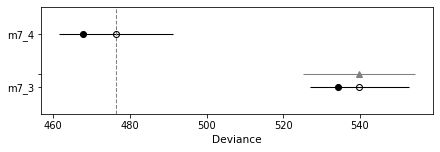

In [42]:
az.plot_compare(comp_df);

###### Code 7.6

In [104]:
rugged_seq = np.arange(-1, 8, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_m7_4['br'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_m7_4['br'])))


mu_pred_NotAfrica = trace_m7_4['a'] + trace_m7_4['br'] * rugged_seq[:, None] + trace_m7_4['ba'] * 0
mu_pred_Africa = trace_m7_4['a'] + trace_m7_4['br'] * rugged_seq[:, None] + trace_m7_4['ba'] * 1

###### Figure 7.3

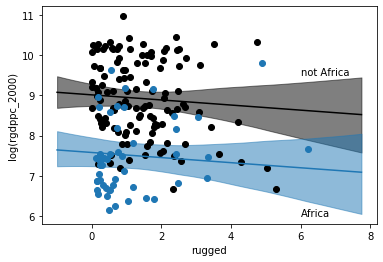

In [119]:
mu_mean0 = mu_pred_NotAfrica.mean(axis=1)
mu_mean1 = mu_pred_Africa.mean(axis=1)

# non-african countries
plt.plot(d_a0["rugged"], d_a0["log_gdp"], 'ko')
plt.plot(rugged_seq, mu_mean0, 'k')
az.plot_hpd(rugged_seq, mu_pred_NotAfrica.T, credible_interval=0.97, color='k')

# african countries
plt.plot(d_a1["rugged"], d_a1["log_gdp"], 'C0o')
plt.plot(rugged_seq, mu_mean1, 'C0')
az.plot_hpd(rugged_seq, mu_pred_Africa.T, credible_interval=0.97, color='C0')
plt.annotate('not Africa', xy=(6, 9.5))
plt.annotate('Africa', xy=(6, 6))
plt.ylabel('log(rgdppc_2000)')
plt.xlabel('rugged');

###### Code 7.7

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 770.64draws/s]


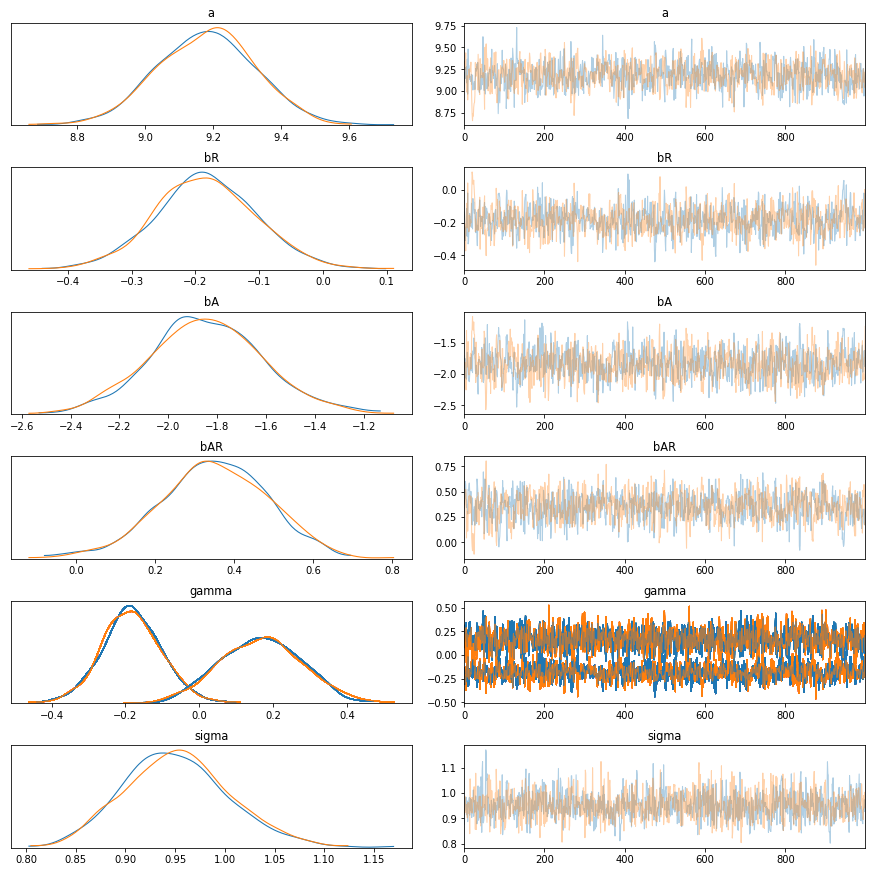

In [121]:
with pm.Model() as m7_5:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    gamma = pm.Deterministic('gamma', bR + bAR * dd["cont_africa"])
    mu = pm.Deterministic('mu', a + gamma * dd["rugged"] + bA * dd["cont_africa"])
    sigma = pm.Uniform('sigma', 0, 10)
    r = pm.Normal('rugged', mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace_m7_5 = pm.sample(1000, tune=1000)

varnames = ['~mu']
pm.traceplot(trace_m7_5, varnames);

###### Code 7.8

In [124]:
comp_df = az.compare({
    'm7_3': trace_m7_3,
    'm7_4': trace_m7_4,
    'm7_5': trace_m7_5,
}, method='pseudo-BMA')

comp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m7_5,0,469.692,5.18408,0,0.966326,14.498,0,True,deviance
m7_4,1,476.406,4.32303,6.71358,0.0336735,14.8213,5.95888,True,deviance
m7_3,2,539.843,2.74205,70.1511,5.64932e-16,12.9427,14.5815,False,deviance


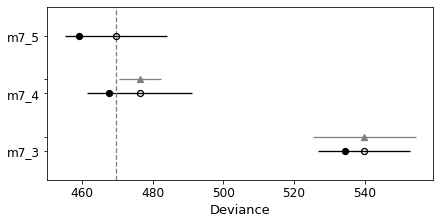

In [125]:
az.plot_compare(comp_df);

###### Code 7.9

In [126]:
with pm.Model() as m7_6:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + bR * dd["rugged"] + bAR * dd["cont_africa"] * dd["cont_africa"] + bA * dd["cont_africa"])
    sigma = pm.Uniform('sigma', 0, 10)
    r = pm.Normal('rugged', mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace_m7_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:07<00:00, 536.12draws/s]


###### Code 7.10

In [191]:
rugged_seq = np.arange(-1, 8, 0.25)

# compute mu over samples
mu_pred_NotAfrica = trace_m7_5['a'] + trace_m7_5['bR'] * rugged_seq[:, None] + trace_m7_5['bA'] * 0 + trace_m7_5['bAR'] * 0 * rugged_seq[:, None]
mu_pred_Africa = trace_m7_5['a'] + trace_m7_5['bR'] * rugged_seq[:, None] + trace_m7_5['bA'] * 1 + trace_m7_5['bAR'] * 1 * rugged_seq[:, None]

###### Code 7.11 & Figure 7.4

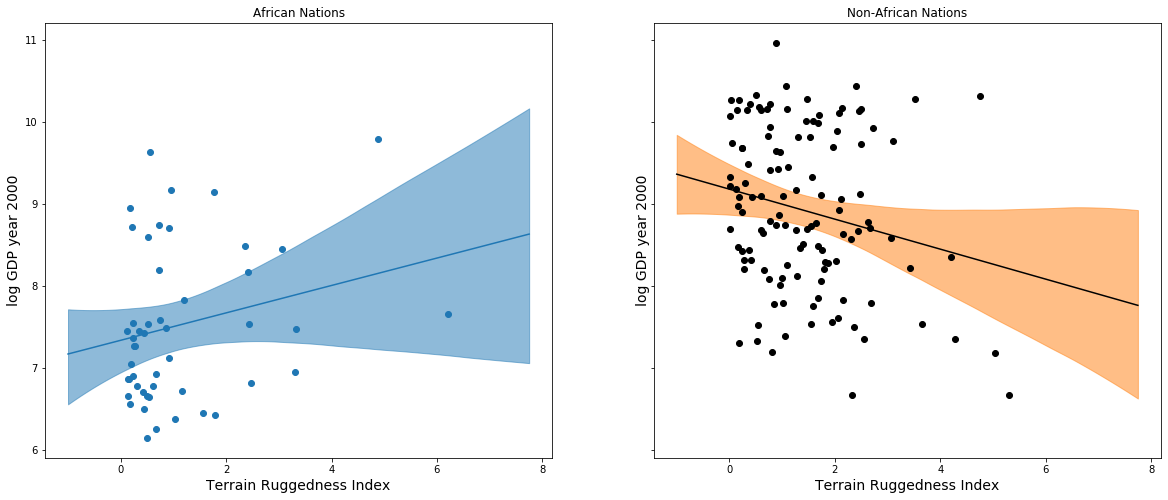

In [159]:
mu_mean0 = mu_pred_NotAfrica.mean(axis=1)
mu_mean1 = mu_pred_Africa.mean(axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8), sharey=True)


ax1.plot(d_a1["rugged"], d_a1["log_gdp"], 'C0o')
ax1.plot(rugged_seq, mu_mean1, 'C0')
az.plot_hpd(rugged_seq, mu_pred_Africa.T, ax=ax1, credible_interval=0.97, color='C0')
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)

ax2.plot(d_a0["rugged"], d_a0["log_gdp"], 'ko')
ax2.plot(rugged_seq, mu_mean0, 'k')
az.plot_hpd(rugged_seq, mu_pred_NotAfrica.T, ax=ax2, credible_interval=0.97)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14)

plt.show();

###### Code 7.12

In [164]:
varnames = ['~mu', '~gamma']
az.summary(trace_m7_5, varnames, credible_interval=.89).round(3)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.179,0.145,8.949,9.400,0.005,0.003,892.0,892.0,898.0,866.0,1.0
bR,-0.183,0.081,-0.317,-0.061,0.003,0.002,908.0,908.0,911.0,933.0,1.0
bA,-1.842,0.229,-2.183,-1.445,0.008,0.006,804.0,804.0,811.0,813.0,1.0
bAR,0.350,0.135,0.148,0.574,0.005,0.003,828.0,828.0,839.0,791.0,1.0
sigma,0.952,0.053,0.870,1.036,0.001,0.001,1464.0,1458.0,1472.0,1218.0,1.0


###### Code 7.13

In [167]:
gamma_Africa = trace_m7_5["bR"] + trace_m7_5["bAR"] * 1
gamma_notAfrica = trace_m7_5["bR"] + trace_m7_5["bAR"] * 0

###### Code 7.14

In [168]:
print("Gamma within Africa: {:.2f}".format(gamma_Africa.mean()))
print("Gamma outside Africa: {:.2f}".format(gamma_notAfrica.mean()))

Gamma within Africa: 0.17
Gamma outside Africa: -0.18


###### Code 7.15 & Figure 7.5

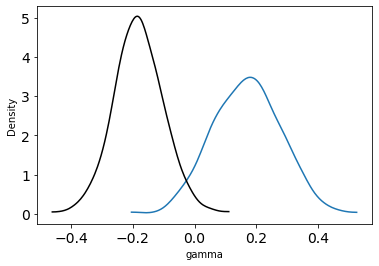

In [170]:
_, ax = plt.subplots()
ax.set_xlabel('gamma')
ax.set_ylabel('Density')
ax.set_ylim(top=5.25)
az.plot_kde(gamma_Africa)
az.plot_kde(gamma_notAfrica, plot_kwargs={'color':'k'});

###### Code 7.16

In [178]:
diff = gamma_Africa - gamma_notAfrica
np.sum(diff < 0) / np.size(diff)

0.008

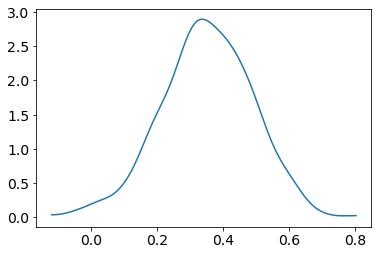

In [176]:
az.plot_kde(diff)

### Symmetry of the linear interaction

###### Code 7.17

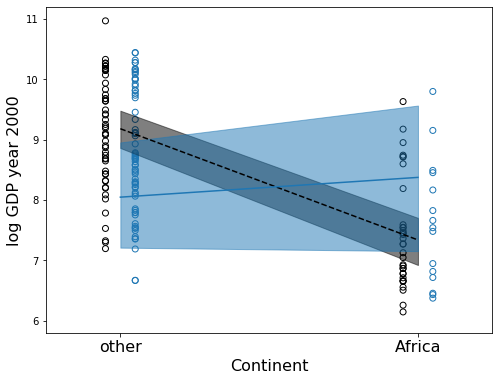

In [254]:
q_rugged = np.array([np.min(dd.rugged), np.max(dd.rugged)])


mu_ruggedlo = trace_m7_5['a'] + trace_m7_5['bR'] * q_rugged[0] + trace_m7_5['bA'] * np.array([0,1])[:, None] + trace_m7_5['bAR'] * q_rugged[0] * np.array([0,1])[:, None]
mu_ruggedlo_mean = mu_ruggedlo.mean(1)
mu_ruggedlo_hpd = pm.hpd(mu_ruggedlo, credible_interval=0.97)

mu_ruggedhi = trace_m7_5['a'] + trace_m7_5['bR'] * q_rugged[1] + trace_m7_5['bA'] * np.array([0,1])[:, None] + trace_m7_5['bAR'] * q_rugged[1] * np.array([0,1])[:, None]
mu_ruggedhi_mean = mu_ruggedhi.mean(1)
mu_ruggedhi_hpd = pm.hpd(mu_ruggedhi, credible_interval=0.97)

med_r = dd.rugged.median()
ox = dd.rugged > med_r

plt.figure(figsize=(8,6))
plt.scatter(dd.cont_africa + np.where(ox, 1, -1) * 0.05, np.log(dd.rgdppc_2000), edgecolors=np.where(ox, 'C0', 'k'), facecolors='none')
plt.plot([0,1], mu_ruggedlo_mean, 'k--')
az.plot_hpd([0,1], mu_ruggedlo.T, credible_interval=0.97, color='k',fill_kwargs={'alpha': 0.5})
plt.plot([0,1], mu_ruggedhi_mean, 'C0')
az.plot_hpd([0,1], mu_ruggedhi.T, credible_interval=0.97, color='C0',fill_kwargs={'alpha': 0.5})

axes = plt.gca()
axes.set_xlim([-0.25, 1.25])
axes.set_ylim([5.8, 11.2])
axes.set_xticks([0, 1])
axes.set_xticklabels(['other', 'Africa'], fontsize=16)
plt.ylabel('log GDP year 2000', fontsize=16)
plt.xlabel('Continent', fontsize=16);

### Continuous Interactions

###### Code 7.18

In [255]:
d = pd.read_csv('../../data/tulips.csv', sep=';')
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


###### Code 7.19

In [261]:
with pm.Model() as m7_6:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', 0, 100)
    mu = pm.Deterministic('mu', a + bW * d.water + bS * d.shade)
    blooms = pm.Normal('blooms', mu=mu, sd=sigma, observed=d.blooms)
    map_m7_6 = pm.find_MAP()

with pm.Model() as m7_7:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', 0, 100)
    mu = pm.Deterministic('mu', a + bW * d.water + bS * d.shade + bWS * d.water * d.shade)
    blooms = pm.Normal('blooms', mu=mu, sd=sigma, observed=d.blooms)
    map_m7_7 = pm.find_MAP()
    

logp = -175.26, ||grad|| = 0.0011502: 100%|██████████| 24/24 [00:00<00:00, 1553.37it/s]  
logp = -170.17, ||grad|| = 0.012971: 100%|██████████| 54/54 [00:00<00:00, 1730.10it/s]    


###### Code 7.20

In [267]:
with pm.Model() as m7_6:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', 0, 100)
    mu = pm.Deterministic('mu', a + bW * d.water + bS * d.shade)
    blooms = pm.Normal('blooms', mu=mu, sd=sigma, observed=d.blooms)
    trace_m7_6 = pm.sample(1000, tune=1000)
    map_m7_6 = pm.find_MAP(method='Powell')

with pm.Model() as m7_7:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', 0, 100)
    mu = pm.Deterministic('mu', a + bW * d.water + bS * d.shade + bWS * d.water * d.shade)
    blooms = pm.Normal('blooms', mu=mu, sd=sigma, observed=d.blooms)
    trace_m7_7 = pm.sample(1000, tune=1000)
    map_m7_7 = pm.find_MAP(method='Powell')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bS, bW, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 875.66draws/s] 
logp = -170.22, ||grad|| = 0.11488: 100%|██████████| 224/224 [00:00<00:00, 1973.78it/s]        
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bWS, bS, bW, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:08<00:00, 485.01draws/s]
The acceptance probability does not match the target. It is 0.9032036147218774, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
logp = -176.57, ||grad|| = 1.3111: 100%|██████████| 640/640 [00:00<00:00, 2144.37it/s]         


###### Code 7.21

In [268]:
pd.DataFrame({
    'm7_6': pm.summary(map_m7_6, var_names=['~mu'])['mean'],
    'm7_7': pm.summary(map_m7_7, var_names=['~mu'])['mean']
})

arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.


,m7_6,m7_7
a,88.094,98.234
bS,-38.870,-41.508
bW,58.994,53.392
bWS,NaN,1.574
sigma,58.821,60.027
sigma_interval__,0.357,0.407


###### Code 7.22

In [269]:
pm.compare({
    'm7_6': trace_m7_6,
    'm7_7': trace_m7_7
})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m7_7,0,293.764,3.90875,0,0.965398,6.82209,0,True,deviance
m7_6,1,303.675,3.68005,9.91015,0.0346023,7.04928,3.70075,True,deviance


###### Code 7.23

In [270]:
d['shade_c'] = d.shade - d.shade.mean()
d['water_c'] = d.water - d.water.mean()

###### Code 7.24

In [271]:
with pm.Model() as m7_8:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', 0, 100)
    mu = pm.Deterministic('mu', a + bW * d.water_c + bS * d.shade_c)
    blooms = pm.Normal('blooms', mu=mu, sd=sigma, observed=d.blooms)
    trace_m7_8 = pm.sample(1000, tune=1000)
    map_m7_8 = pm.find_MAP(method='Powell')

with pm.Model() as m7_9:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', 0, 100)
    mu = pm.Deterministic('mu', a + bW * d.water_c + bS * d.shade_c + bWS * d.water_c * d.shade_c)
    blooms = pm.Normal('blooms', mu=mu, sd=sigma, observed=d.blooms)
    trace_m7_9 = pm.sample(1000, tune=1000)
    map_m7_9 = pm.find_MAP(method='Powell')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bS, bW, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1528.73draws/s]
logp = -175.92, ||grad|| = 3.6735e-09: 100%|██████████| 196/196 [00:00<00:00, 2086.11it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bWS, bS, bW, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1584.29draws/s]
logp = -179.9, ||grad|| = 6.6863e-09: 100%|██████████| 245/245 [00:00<00:00, 1770.68it/s] 


In [272]:
pd.DataFrame({
    'm7_8': pm.summary(map_m7_8, var_names=['~mu'])['mean'],
    'm7_9': pm.summary(map_m7_9, var_names=['~mu'])['mean']
})

arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.


,m7_8,m7_9
a,124.387,124.387
bS,-39.413,-39.413
bW,71.812,71.812
bWS,NaN,-48.786
sigma,100.000,100.000
sigma_interval__,44.804,44.804


###### Code 7.25

In [274]:
map_m7_7['a'] + map_m7_7['bW'] * 2 + map_m7_7['bS'] * 2 + map_m7_7['bWS'] * 2 * 2

128.29998941417296

###### Code 7.26

In [277]:
map_m7_9['a'] + map_m7_9['bW'] * 0 + map_m7_9['bS'] * 0 + map_m7_9['bWS'] * 0 * 0

124.3867865072971

###### Code 7.27

In [278]:
az.summary(trace_m7_9, var_names=['~mu'], kind='stats')

,mean,sd,hpd_3%,hpd_97%
a,127.598,9.953,108.926,145.732
bW,74.847,12.339,52.853,97.810
bS,-40.882,12.300,-63.534,-17.031
bWS,-51.253,14.905,-79.859,-23.271
sigma,51.996,8.424,37.960,67.859


###### Code 7.28

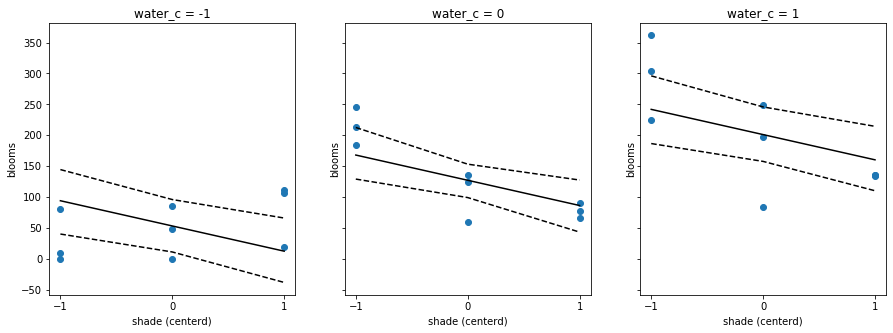

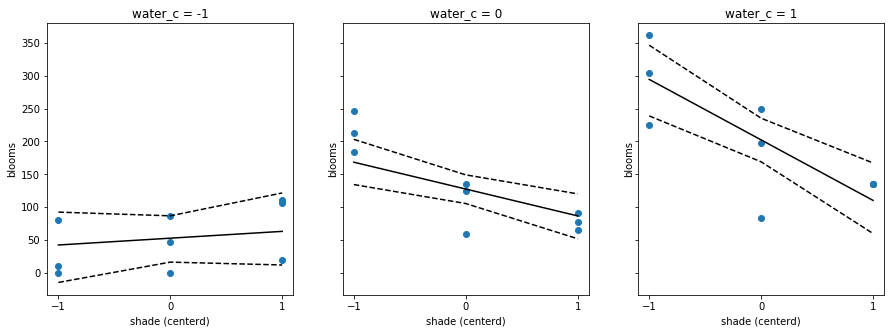

In [289]:
# No interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
# Loop over values of water_c and plot predictions.
shade_seq = np.arange(-1, 2, 1)

for ax, w in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.water_c == w]
    ax.plot(dt.shade-np.mean(dt.shade), dt.blooms, 'C0o')
    mu_w = trace_m7_8['a'] + trace_m7_8['bW'] * w + trace_m7_8['bS'] * shade_seq[:, None]
    mu_mean_w = mu_w.mean(1)
    mu_hpd_w = pm.hpd(mu_w.T, credible_interval=0.97)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(shade_seq, mu_mean_w, 'k')
    ax.plot(shade_seq, mu_hpd_w.T[0], 'k--')
    ax.plot(shade_seq, mu_hpd_w.T[1], 'k--')
    ax.set_ylabel('blooms')
    ax.set_xlabel('shade (centerd)')
    ax.set_title('water_c = {:d}'.format(w))
    ax.set_xticks(shade_seq)
    
# Interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

for ax, w in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.water_c == w]
    ax.plot(dt.shade-np.mean(dt.shade), dt.blooms, 'C0o')
    mu_w = trace_m7_9['a'] + trace_m7_9['bW'] * w + trace_m7_9['bS'] * shade_seq[:, None] + trace_m7_9['bWS'] * w * shade_seq[:, None]
    mu_mean_w = mu_w.mean(1)
    mu_hpd_w = pm.hpd(mu_w.T, credible_interval=0.97)
    ax.plot(shade_seq, mu_mean_w, 'k')
    ax.plot(shade_seq, mu_hpd_w.T[0], 'k--')
    ax.plot(shade_seq, mu_hpd_w.T[1], 'k--')
    ax.set_ylabel('blooms')
    ax.set_xlabel('shade (centerd)')
    ax.set_title('water_c = {:d}'.format(w))
    ax.set_xticks(shade_seq)

### Interactions in design formulas

###### Code 7.29

In [290]:
m_7_x = smf.ols('blooms ~ shade + water + shade * water', data=d).fit()

###### Code 7.30

In [291]:
m_7_x = smf.ols('blooms ~ shade * water', data=d).fit()

###### Code 7.31

In [292]:
m_7_x = smf.ols('blooms ~ shade * water - water', data=d).fit()

###### Code 7.32

In [293]:
m_7_x = smf.ols('blooms ~ shade * water * bed', data=d).fit()

###### Code 7.33

In [294]:
from patsy import dmatrix
x, y, z = 1, 1, 1
d_matrix = dmatrix('~ x * y * w')
d_matrix.design_info.column_names

['Intercept', 'x', 'y', 'x:y', 'w', 'x:w', 'y:w', 'x:y:w']

In [14]:
import sys, IPython, scipy, matplotlib, platform, statsmodels, arviz
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\nArviz {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__, arviz.__version__))



This notebook was created using:
Python 3.7.6
IPython 7.12.0
PyMC3 3.8
Seaborn 0.10.0
NumPy 1.18.1
Pandas 1.0.1
Statsmodels 0.11.0
Matplotlib 3.1.3
Scipy 1.4.1
Arviz 0.6.1


